In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import ml_util as util
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import mean_absolute_error


In [2]:
training = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')
df_full = pd.concat([training, test])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min     

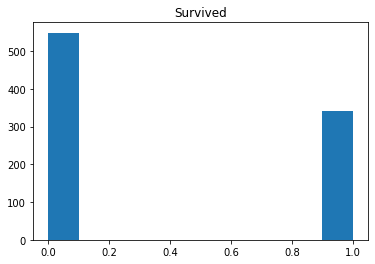

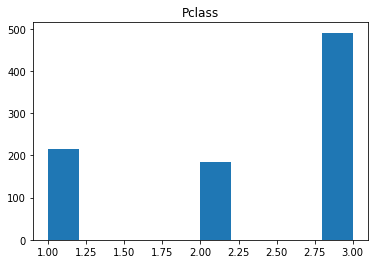

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


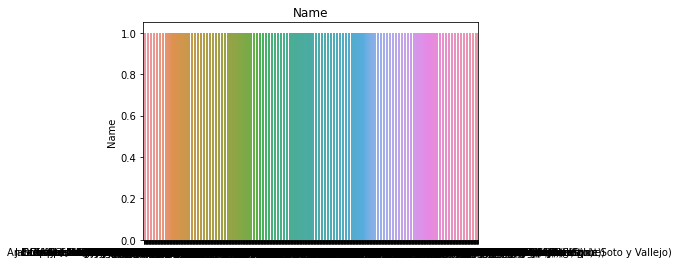

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


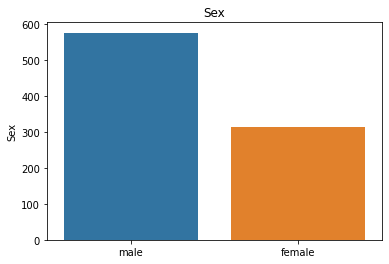

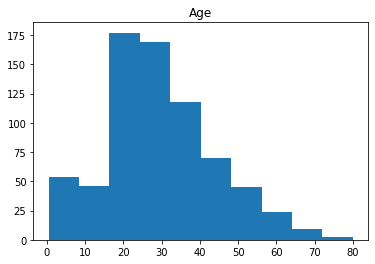

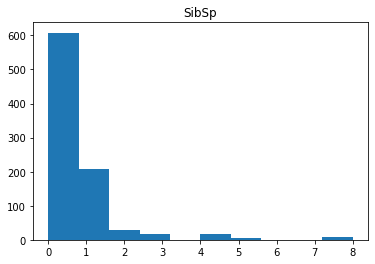

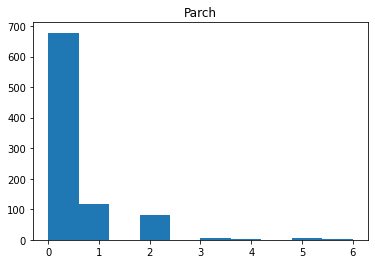

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


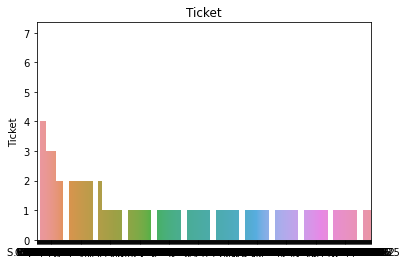

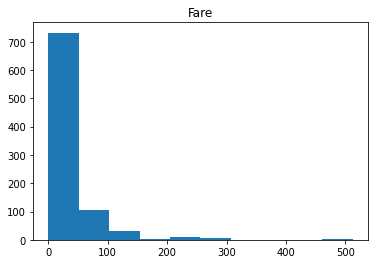

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


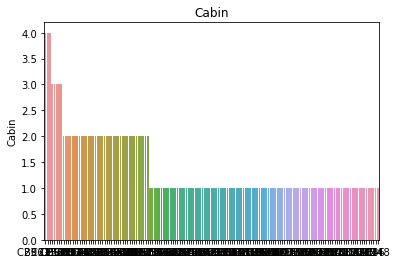

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


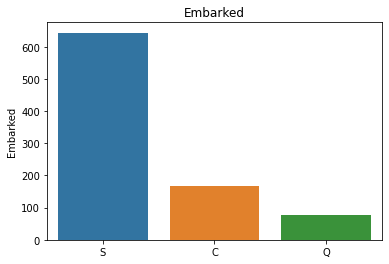

In [3]:

util.understanding(training)

In [4]:
print(training.Name.value_counts())
training['Sur'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

common_sur = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev']
training.Sur = training.Sur.apply(lambda x: 'Other' if x not in common_sur else x)
training.Sur.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64


Mr        517
Miss      182
Mrs       125
Master     40
Other      14
Dr          7
Rev         6
Name: Sur, dtype: int64

In [5]:
test['Sur'] = test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
test.Sur = test.Sur.apply(lambda x: 'Other' if x not in common_sur else x)

In [6]:
training.Sex = training.Sex.apply(lambda x: 0 if x == 'male' else 1)
training.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [7]:
test.Sex = test.Sex.apply(lambda x: 0 if x == 'male' else 1)

In [8]:
print(training.Age.value_counts())
median = round((training.Age.median()), 2)
median

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64


28.0

In [9]:
training.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [10]:
training.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [11]:
training.Ticket.value_counts()
training.Ticket_grouped = training.Ticket.apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0].lower() if len(x.replace('.', '').replace('/', '').split(' ')) > 1 else '0')
training.Ticket_grouped = training.Ticket_grouped.apply(lambda x: 0 if x == '0' else 1)
print(training.Ticket_grouped.value_counts())

0    665
1    226
Name: Ticket, dtype: int64


/tmp/ipykernel_151696/664547920.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  training.Ticket_grouped = training.Ticket.apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0].lower() if len(x.replace('.', '').replace('/', '').split(' ')) > 1 else '0')


In [12]:
test.Ticket_grouped = test.Ticket.apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0].lower() if len(x.replace('.', '').replace('/', '').split(' ')) > 1 else '0')
test.Ticket_grouped = test.Ticket_grouped.apply(lambda x: 0 if x == '0' else 1)

/tmp/ipykernel_151696/1799833981.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.Ticket_grouped = test.Ticket.apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0].lower() if len(x.replace('.', '').replace('/', '').split(' ')) > 1 else '0')


In [13]:
training.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

In [14]:
training.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [15]:
training.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
training.Survived = training.Survived.apply(lambda x: 1 if x == 'yes' else 0)

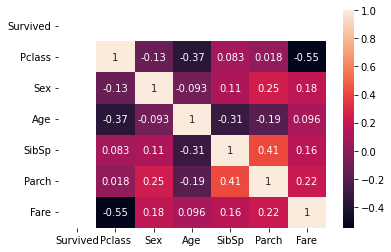

In [17]:
util.heat(training)

In [18]:
X_train = training.copy()
X_test = test.copy()

cols_to_drop = ['Cabin', 'Ticket', 'Name']

X_test.drop(cols_to_drop, axis=1, inplace=True)
X_train.drop(cols_to_drop, axis=1, inplace=True)

In [19]:
X_train.dropna(subset=['Embarked'], inplace=True)
X_test.dropna(subset=['Embarked'], inplace=True)

X_train.Age = X_train.Age.fillna(median)
X_test.Age = X_train.Age.fillna(median)

In [20]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [21]:
X_train.head(
    
)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sur_Dr,Sur_Master,Sur_Miss,Sur_Mr,Sur_Mrs,Sur_Other,Sur_Rev
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0,0,1,0,0,0,1,0,0,0
2,0,1,1,38.0,1,0,71.2833,1,0,0,0,0,0,0,1,0,0
3,0,3,1,26.0,0,0,7.9250,0,0,1,0,0,1,0,0,0,0
4,0,1,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,1,0,0
5,0,3,0,35.0,0,0,8.0500,0,0,1,0,0,0,1,0,0,0


In [22]:
y_train = X_train.Survived
X_train.drop(['Survived'], axis=1, inplace=True)
model = XGBClassifier(random_state=0, n_estimators=500, learning_rate = 0.5)
model.fit(X_train, y_train)

cv = cross_val_score(model,X_train,y_train,cv=5)
cv

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:45:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:45:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:45:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([1., 1., 1., 1., 1.])